In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.stats import mode
from tqdm.notebook import tqdm
from p_tqdm import p_map
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
df_combined = pd.read_csv('/ndata/chaban/pharmapack/CSVs/lopq/LOPQ:BOTH:resnet50:512:20:part.csv', index_col=None)
excluded_classes = ['0235_D01_S001', '0200_D01_S001', '0049_D01_S001', '0842_D01_S001', '0337_D01_S001', '0263_D01_S001', '0735_D01_S001', '0541_D01_S001', '0311_D01_S001']
len(excluded_classes)
df_combined = df_combined[~df_combined.package_actual.isin(excluded_classes)]
df_combined.package_actual.nunique()

20

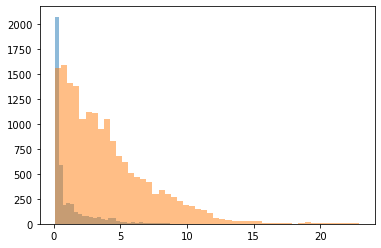

In [9]:
s = plt.hist(df_combined[df_combined.match].distance, bins=50, alpha=0.5)
s1 = plt.hist(df_combined[~df_combined.match].distance, bins=50, alpha=0.5)

In [ ]:
df_bad_samples = pd.read_csv('to_investigate.csv', index_col=None)

In [ ]:
df_selected = df_combined[df_combined.sample_actual.isin(df_bad_samples['sample_actual'].to_list())]

In [11]:
dfs = [x for _, x in df_combined.groupby('sample_actual')]

In [13]:
df = dfs[0]

sample_actual = df.iloc[0].sample_actual
package_actual = df.iloc[0].package_actual
alg = df.algorithm.unique()[0]
df[df.algorithm == 'MI1']

,distance,uuid_actual,uuid_predicted,sample_actual,package_actual,descriptor_actual,package_predicted,algorithm,match
14800,1.098901,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0010,PFP_Ph1_P0083_D01_S001_C3_az360_side1:0009,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,10,0083_D01_S001,MI1,True
14801,1.643249,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0010,PFP_Ph3_P0083_D01_S001_C3_az360_side1:0008,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,10,0083_D01_S001,MI1,True
14802,4.110459,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0010,PFP_Ph2_P0106_D02_S001_C3_az360_side1:0003,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,10,0106_D02_S001,MI1,False
14803,4.368579,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0010,PFP_Ph1_P0420_D01_S001_C3_az360_side1:0013,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,10,0420_D01_S001,MI1,False
14804,4.372701,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0010,PFP_Ph2_P0692_D01_S001_C2_az360_side1:0007,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,10,0692_D01_S001,MI1,False
...,...,...,...,...,...,...,...,...,...
21835,5.306495,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0029,PFP_Ph3_P0083_D01_S001_C3_az360_side1:0050,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,29,0083_D01_S001,MI1,True
21836,5.346574,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0029,PFP_Ph3_P0083_D01_S001_C3_az360_side1:0037,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,29,0083_D01_S001,MI1,True
21837,5.349167,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0029,PFP_Ph2_P0083_D01_S001_C3_az360_side1:0041,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,29,0083_D01_S001,MI1,True
21838,5.349433,PFP_Ph1_P0083_D01_S001_C3_az260_side1:0029,PFP_Ph2_P0083_D01_S001_C3_az360_side1:0037,Ph1_P0083_D01_S001_C3_az260,0083_D01_S001,29,0083_D01_S001,MI1,True


In [14]:
# for df in dfs:
df = dfs[1]

sample_actual = df.iloc[0].sample_actual
package_actual = df.iloc[0].package_actual

alg_guesses = []
for alg in df.algorithm.unique():
    df_piv = df[df.algorithm == alg].pivot_table(
        index='package_predicted', columns='descriptor_actual', values='distance', fill_value=np.nan,
        aggfunc=[np.mean, np.median, 'size', sum, min, 'std', np.var]#, ]
    )
    df_piv = df_piv.reset_index()

    df_rank = pd.DataFrame(columns=df_piv.columns)

    df_rank['index'] = df_piv['index']

    rank_ascending = ['mean', 'median', 'sum', 'std', 'var'] # 
    df_rank.loc[:, rank_ascending] = df_piv[rank_ascending].rank(method='dense', na_option='bottom', ascending=True)

    rank_descending = ['size']
    df_rank.loc[:, rank_descending] = df_piv[rank_descending].rank(method='dense', na_option='bottom', ascending=False)

    guess_rankings = dict()

    for desc_index in df_piv.columns.levels[1].to_list()[:-1]:
        df_rank.loc[:, ('rank_sum', desc_index)] = df_rank.loc[:, (rank_ascending + rank_descending, desc_index)].sum(axis=1)
        guesses = df_rank.loc[df_rank.loc[:, ('rank_sum', desc_index)].nsmallest(10).index, 'index'].to_list()

        for rank, guess in enumerate(guesses, start=1):
            if guess in guess_rankings.keys():
                guess_rankings[guess].append(rank)
            else:
                guess_rankings[guess] = [rank]

    top_guesses = [s[0] for s in sorted(guess_rankings.items(), key=lambda x: len(x[1]), reverse=True)][:10]
    alg_guesses.extend(top_guesses)
    #return [sample_actual, package_actual] + top_guesses
print(package_actual in alg_guesses)

True


In [17]:
df

,distance,uuid_actual,uuid_predicted,sample_actual,package_actual,descriptor_actual,package_predicted,algorithm,match
280,0.508244,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0005,PFP_Ph1_P0491_D01_S004_C3_az360_side1:0004,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,5,0491_D01_S004,MSER,False
281,0.537190,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0005,PFP_Ph1_P0491_D01_S003_C3_az360_side1:0005,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,5,0491_D01_S003,MSER,False
282,0.566595,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0005,PFP_Ph1_P0491_D02_S001_C3_az360_side1:0008,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,5,0491_D02_S001,MSER,True
283,0.630891,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0005,PFP_Ph1_P0062_D01_S001_C3_az360_side1:0005,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,5,0062_D01_S001,MSER,False
284,0.672090,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0005,PFP_Ph1_P0491_D02_S002_C3_az360_side1:0006,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,5,0491_D02_S002,MSER,False
...,...,...,...,...,...,...,...,...,...
21655,2.031136,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0002,PFP_Ph2_P0491_D02_S002_C3_az360_side1:0002,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,2,0491_D02_S002,MI1,False
21656,2.109808,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0002,PFP_Ph2_P0491_D01_S002_C3_az360_side1:0001,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,2,0491_D01_S002,MI1,False
21657,2.141041,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0002,PFP_Ph2_P0491_D01_S004_C3_az360_side1:0002,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,2,0491_D01_S004,MI1,False
21658,2.157441,PFP_Ph1_P0491_D02_S001_C3_az180_side1:0002,PFP_Ph2_P0491_D01_S003_C3_az360_side1:0001,Ph1_P0491_D02_S001_C3_az180,0491_D02_S001,2,0491_D01_S003,MI1,False


In [ ]:
dasd = df.descriptor_actual.max() // 10

df['package_predicted'].value_counts().reset_index(name="count").query(f"count > {dasd}")

In [ ]:
sorted(df_piv['size'].isnull().sum(axis=1).unique())

In [ ]:
df_piv['size'].shape

In [ ]:
sample_actual

In [ ]:
df = dfs[2]

sample_actual = df.iloc[0].sample_actual
package_actual = df.iloc[0].package_actual
df[df.distance < 1].package_predicted.value_counts()

In [ ]:
df[df.algorithm == 'MI1'].descriptor_actual.max()